# Steering with previously calculated directions
We apply activation addition to steer the generated text into positve and negative concept directions respectively.
We evaluate the generated text on coherence and content.

### User data
You need to specify the current working directory and the huggingface [access token](https://huggingface.co/docs/hub/security-tokens) to use this notebook.

In [1]:
# modify to your current working directory (the directory where this notebook is )
cwd = "exploring_directions"

# enter your authentication token from huggingface and press enter to access the models
auth_token = input()

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification, AutoConfig
from tqdm import tqdm
import pandas as pd
import gc
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import re
import math
import numpy as np
import os
import torch.nn.functional as F
from scipy.special import softmax


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
# import my modules
import sys
import importlib
# join the path to the modules to the current working directory

sys.path.append(os.path.join(cwd, "modules"))

from wrapping import WrappedModel
from utils import *

In [6]:
# define directories
results_dir = os.path.join(cwd, 'results/')
plots_dir = os.path.join(cwd, 'plots/')
data_dir = os.path.join(cwd, 'data/')

data_file = os.path.join(data_dir, 'test_sentences.txt')
num_test_sentences = 500
random_seed = 42

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {DEVICE}")

# parameters
calc_generations = False

# set to True if you want to evaluate the generated data
evaluate_logprobs = True
evaluate_sentiment = True

block_name = "decoder_block"
max_new_tokens = 40 # how many tokens to generate while steering
layer_ids = [0, 5, 10, 15, 20, 25] # which layers to steer
batch_size = 128

# directions have different norms for different methods. We need to choose coefficients appropriately
# we can take the norms of one method that has relation to actual differences in hidden layers as coefficients for all methods
norm_method = "ClassMeans"

# we use norms of ClassMeans directions as coefficients, but utility is based on differences, so we need to divide by 2 
multiplier = 0.5

device: cuda


## Load data

We need some setup to generate sentences. Like the beginning of a scenario, that we then generate the end to while adding a steering vector. We can just get some sentences from the utility test set which are easily divisible into two parts, throw away the second part and use the first part as the generation seed.

In [7]:
# make data
X_test = load_util_data(data_dir=os.path.join(cwd, 'data/ethics/utilitarianism/'), split='test')
X_test, y_test = mix_util_pairs(X_test)

test_data_idxs, split_sentences = find_two_sentences(X_test[:, 0], split_str1=".", split_str2=",", larger_than1=2, larger_than2=1)

with open(data_file, "w") as f:
    for s in split_sentences:
        f.write(s + " \n")

In [8]:
# load data
with open(data_file, 'r') as f:
    test_sentences = [line.strip() for line in f]

np.random.seed(random_seed)
idxs = np.random.choice(len(test_sentences), num_test_sentences, replace=False)
test_sentences = [test_sentences[idx] for idx in idxs]
for i in range(10):
    print(test_sentences[i])

I went to city hall.
After work, I went to the bank to make the nightly deposit.
I wrote my representative because I never got my income tax refund.
On my way to work I got stuck behind a large Semi truck.
I drove to the DMV.
I tried to make a viral video to post on YouTube.
As I was driving,
When I went on my first date,
I went to see a medieval village.
After I took my dog's toy away from her,


## Load model

In [9]:
# load model
model_name = "Llama-2-7b-chat-hf"
model_path = f"meta-llama/{model_name}"
precision = torch.bfloat16
model = AutoModelForCausalLM.from_pretrained(model_path, token=auth_token, device_map="auto").to(device=DEVICE, dtype=precision)
model.eval()

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path, token=auth_token, device_map="auto")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left' 

num_hidden_layers = model.config.num_hidden_layers
hidden_size = model.config.hidden_size

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/data/ann_kathrin_dombrowski/miniconda3/envs/jup/lib/python3.11/site-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [10]:
# create wrapped model
wrapped_model = WrappedModel(model, tokenizer)
# make sure nothing is wrapped from previous runs
wrapped_model.unwrap()

# Steering

### Load directions

In [11]:
# load pkl directions
with open(os.path.join(results_dir, f'utility_directions_{model_name}.pkl'), "rb") as f:
    all_directions = pickle.load(f)

# remove random directions
if "Random" in all_directions:
    all_directions.pop("Random", None)

method_names = list(all_directions.keys())
print(method_names)

['PCA_diffs', 'PCA', 'ClassMeans', 'K-Means', 'OnePrompt', 'LogReg']


### Define multipliers for scaling the steering vectors
We need to define the scaling coefficient for each layer separately. We can take the norms of one method that has relation to actual differences in hidden layers as coefficients for all methods for example the class means method. As the class mean norm would be the difference between high utility and low utility examples but we are starting from neutral, we multiply by 0.5.

/data/ann_kathrin_dombrowski/miniconda3/envs/jup/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/data/ann_kathrin_dombrowski/miniconda3/envs/jup/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/data/ann_kathrin_dombrowski/miniconda3/envs/jup/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/data/ann_kathrin_dombrowski/miniconda3/envs/jup/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning

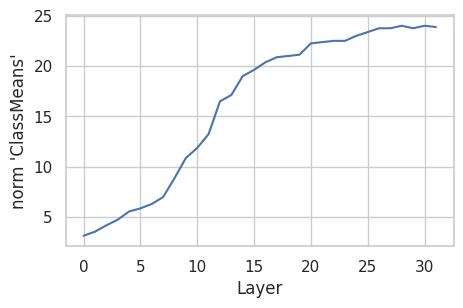

In [12]:
norm_directions = all_directions[norm_method]
# convert dict to tensor
norm_directions = {k: torch.tensor(v).to(device=DEVICE, dtype=precision) for k, v in norm_directions.items()}

coeffs = {k:multiplier*v.norm().squeeze() for k, v in norm_directions.items()}

# Use Seaborn to set the style and context
sns.set(style="whitegrid", context="notebook")

plt.figure(figsize=(5, 3))

# Plot using Seaborn
sns.lineplot(x=range(len(coeffs)), y=[c.item() for k, c in coeffs.items()])

# Adding grid, labels and title
plt.grid(True)
plt.xlabel("Layer")
plt.ylabel(f"norm '{norm_method}'")
plt.savefig(os.path.join(plots_dir, f"norm_{norm_method}_{model_name}.pdf"), dpi=300)
plt.show()

### Completion with activation addition

In [13]:
if calc_generations:
    
    # completions without activation steering
    generations = []
    wrapped_model.unwrap()
    for sentence_batch in batchify(test_sentences, batch_size):
        generated = wrapped_model.generate(sentence_batch, max_new_tokens=max_new_tokens, use_cache=True)
        generations.extend(generated)

    # save generations as text files
    with open(os.path.join(results_dir, f"generations_neutral.txt"), "w") as f:
        for item in generations:
            # remove newline characters
            item = item.replace("\n", " ")
            f.write("%s\n" % item)


    for method_name in method_names:
        
        print(f"method: {method_name}")

        for layer_id in tqdm(layer_ids):

            generations = {"positive": [], "negative": []}

            wrapped_model.unwrap()
            wrapped_model.wrap_block(layer_id, block_name=block_name)

            direction = torch.tensor(all_directions[method_name][layer_id]).to(device=DEVICE, dtype=precision)
            direction = direction / direction.norm(dim=-1, keepdim=True)

            wrapped_model.reset()
            wrapped_model.set_to_add(layer_id, coeffs[layer_id]*direction, block_name=block_name)

            for sentence_batch in batchify(test_sentences, batch_size):
                generated = wrapped_model.generate(sentence_batch, max_new_tokens=max_new_tokens, use_cache=True)
                generations["positive"].extend(generated)


            wrapped_model.reset()
            wrapped_model.set_to_add(layer_id, -coeffs[layer_id]*direction, block_name=block_name)

            for sentence_batch in batchify(test_sentences, batch_size):
                generated = wrapped_model.generate(sentence_batch, max_new_tokens=max_new_tokens, use_cache=True)
                generations["negative"].extend(generated)

            # save generations as text files
            with open(os.path.join(results_dir, f"generations_positive_{method_name}_{layer_id}.txt"), "w") as f:
                for item in generations["positive"]:
                    # remove newline characters
                    item = item.replace("\n", " ")
                    f.write("%s\n" % item)

            with open(os.path.join(results_dir, f"generations_negative_{method_name}_{layer_id}.txt"), "w") as f:
                for item in generations["negative"]:
                    item = item.replace("\n", " ")
                    f.write("%s\n" % item)

# Evaluate the coherence/likelihood of the generated text

In [17]:
batch_size = 32
wrapped_model.unwrap()
gc.collect()
if evaluate_logprobs:
    probs = {}

    print(f"method: Baseline")
    probs['Baseline'] = {}
    
    all_generations = load_generations(os.path.join(results_dir, f"generations_neutral.txt"))
    logprobs = []
    for sentence_batch in batchify(all_generations, batch_size):
        gc.collect()
        logits, attention_mask, input_ids = get_logits(tokenizer, wrapped_model, sentence_batch, DEVICE)
        p = get_logprobs(logits, input_ids, attention_mask)
        logprobs.extend(list(p.sum(dim=-1).detach().cpu().float().numpy()))

    for layer_id in layer_ids:
        probs['Baseline'][layer_id] = np.mean(logprobs)


    for method_name in method_names:
        gc.collect()
        probs[method_name] = {}
        print(f"method: {method_name}")
        for layer_id in tqdm(layer_ids):
            gc.collect()

            # check if file exists
            if not os.path.exists(os.path.join(results_dir, f"generations_positive_{method_name}_{layer_id}.txt")):
                print(f"File not found: {os.path.join(results_dir, f'generations_positive_{method_name}_{layer_id}.txt')}")
                continue

            # load generations
            all_generations = load_generations(os.path.join(results_dir, f"generations_positive_{method_name}_{layer_id}.txt"))
            all_generations.extend(load_generations(os.path.join(results_dir, f"generations_negative_{method_name}_{layer_id}.txt")))

            # eval
            logprobs = []
            for sentence_batch in batchify(all_generations, batch_size):
                logits, attention_mask, input_ids = get_logits(tokenizer, wrapped_model, sentence_batch, DEVICE)
                p = get_logprobs(logits, input_ids, attention_mask)
                logprobs.extend(list(p.sum(dim=-1).detach().cpu().float().numpy()))

            probs[method_name][layer_id] = np.mean(logprobs)

    plot_lines(probs, "Log probabilities", os.path.join(plots_dir, f"probs_{model_name}.pdf"))
    plot_lines(probs, "Log probabilities", os.path.join(plots_dir, f"probs_{model_name}.png"))

method: Baseline


method: PCA_diffs


 33%|███▎      | 2/6 [00:10<00:21,  5.29s/it]

# Sentiment analysis with sentiment model

In [ ]:
model=None
wrapped_model=None
gc.collect()

In [ ]:
model_path = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left' 
config = AutoConfig.from_pretrained(model_path)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device=DEVICE, dtype=precision)

In [ ]:
if evaluate_sentiment:


    
    sentiment_diffs = {}

    for method_name in method_names:
        gc.collect()
        sentiment_diffs[method_name] = {}
        print(f"method: {method_name}")
        for layer_id in tqdm(layer_ids):
            gc.collect()

            # check if file exists
            if not os.path.exists(os.path.join(results_dir, f"generations_positive_{method_name}_{layer_id}.txt")):
                print(f"File not found: {os.path.join(results_dir, f'generations_positive_{method_name}_{layer_id}.txt')}")
                continue

            # load generations
            generations = {"positive": [], "negative": []}
            generations["positive"] = load_generations(os.path.join(results_dir, f"generations_positive_{method_name}_{layer_id}.txt"))
            generations["negative"] = load_generations(os.path.join(results_dir, f"generations_negative_{method_name}_{layer_id}.txt"))

            outputs = {"positive": [], "negative": []}
            # eval
            for sentence_batch in batchify(generations["positive"], batch_size):
                logits, _, _ = get_logits(tokenizer, sentiment_model, sentence_batch, DEVICE)
                output = softmax(logits.detach().float().cpu().numpy(), axis=-1)
                outputs["positive"].append(output)

            outputs["positive"] = np.concatenate(outputs["positive"], axis=0)

            for sentence_batch in batchify(generations["negative"], batch_size):
                logits, _, _ = get_logits(tokenizer, sentiment_model, sentence_batch, DEVICE)
                output = softmax(logits.detach().float().cpu().numpy(), axis=-1)
                outputs["negative"].append(output)

            outputs["negative"] = np.concatenate(outputs["negative"], axis=0)

            # output has three values per sample: negative, neutral, positive
            # we take the difference between of the positive label predictions
            sentiment_diffs[method_name][layer_id] = np.mean(outputs["positive"][:,-1]-outputs["negative"][:,-1])

    plot_lines(sentiment_diffs, "Sentiment difference", os.path.join(plots_dir, f"sentiment_{model_name}.pdf"))
    plot_lines(sentiment_diffs, "Sentiment difference", os.path.join(plots_dir, f"sentiment_{model_name}.png"))